***
# Modele de prédiction
***

In [1]:
# ====== Importer les library ====== #
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.inspection import permutation_importance
from sklearn.metrics import classification_report,  confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from collections import Counter
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import cross_val_score
from sklearn.metrics import make_scorer



pd.set_option('display.max_columns', None)

In [2]:
# ====== Déterminer les path ====== #
import os
cwd = os.getcwd()

df_path = cwd + '\\dataframe\\'

In [3]:
# ====== Importer les df ====== #
df = pd.read_hdf(df_path + 'df_merge.h5')

df.head(2)

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,comment_count,like_count,message_comments,mainTopic,message_posts,secondTopic,shares,title,time_difference,year,month,weekday,IDENTITY_ATTACK_cube,INSULT_cube,PROFANITY_cube,SEVERE_TOXICITY_cube,THREAT_cube,TOXICITY_cube,comment_count_cube,like_count_cube,shares_cube,messages_clean,emojis,emojis_text,positive,neutral,negative,emoji_count,title_classify
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0,0,"Faux, ce ne sera jamais le temps pour lui car ...",composer-preview,HÉLÈNE BUZZETTI / Jagmeet Singh a soutenu que ...,7FJ4TUHKEFEXFIZI6DY2WAQE4E,0,Les incohérences de l’ingérence,3.0,2023,6,4,0.467562,0.866814,0.872661,0.705121,0.310492,0.838017,0.0,0.0,0.0,Faux jamais temps réélu parti crève faim Jamai...,[],[],0.077610,0.130838,0.791552,0,Environnement
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,1,1,Mon dieu!! On nous prend sérieusement pour des...,composer-preview,HÉLÈNE BUZZETTI / Jagmeet Singh a soutenu que ...,7FJ4TUHKEFEXFIZI6DY2WAQE4E,0,Les incohérences de l’ingérence,18.0,2023,6,4,0.176257,0.551253,0.634546,0.191119,0.178081,0.560745,1.0,1.0,0.0,dieu prend sérieusement idiots,[😅],[grinning_face_with_sweat],0.697028,0.047872,0.255100,1,Environnement


In [45]:

# Faire un tableau par

df_model = df.copy()
df_model['comments_binary'] = np.where(df_model['comment_count']==0, 0, 1)

# # ======= Baseline ======= #  
# col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'shares', 'comments_binary']
# col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'shares', 'comment_count']

# ======= Tout le kit ======= #
df_model = pd.get_dummies(df_model, columns = ['year', 'weekday', 'title_classify'])

col_to_keep = ['IDENTITY_ATTACK', 'INSULT', 'PROFANITY', 'SEVERE_TOXICITY', 'THREAT', 'TOXICITY', 'like_count', 'shares', 'time_difference', 'positive', 'negative', 'comments_binary']
columns = ['year', 'weekday', 'title_classify']

for col in df_model.columns.to_list():
    for column in columns:
        if column in col:
            col_to_keep.append(col)



df_model = df_model[col_to_keep]

# if  'time_difference' in col_to_keep :
#     df_model['time_difference'] = np.where(df_model['time_difference']<0, 0, df_model['time_difference'])

# independent values 
col_independent = []
for col in df_model.columns.tolist():
    if (col != 'comments_binary') & (col != 'comment_count'):
        col_independent.append(col)

if 'comments_binary' in df_model.columns.tolist():
    col_dependent = 'comments_binary'
else :
    col_dependent = 'comment_count'

df_model.head()

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count,shares,time_difference,positive,negative,comments_binary,year_2020,year_2021,year_2022,year_2023,weekday_0,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,title_classify_COVID,title_classify_Environnement,title_classify_Justice,title_classify_Politique,title_classify_Santé,title_classify_Sport,title_classify_Technologie,title_classify_Économie,title_classify_Éducation
0,0.102216,0.651296,0.664565,0.350583,0.029933,0.588517,0,0,3.0,0.077610,0.791552,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
1,0.005476,0.167515,0.255499,0.006981,0.005647,0.176317,1,0,18.0,0.697028,0.255100,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
2,0.029144,0.269578,0.016753,0.006104,0.005864,0.246033,0,0,86.0,0.243069,0.667599,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
3,0.036105,0.402434,0.479813,0.023411,0.008220,0.372227,0,0,94.0,0.685404,0.189553,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0
4,0.280349,0.520819,0.163573,0.169603,0.008790,0.439655,0,0,95.0,0.158446,0.599248,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0


In [8]:
df_model.describe()

,IDENTITY_ATTACK,INSULT,PROFANITY,SEVERE_TOXICITY,THREAT,TOXICITY,like_count,shares,comment_count
count,9.272410e+05,927241.000000,927241.000000,9.272410e+05,927241.000000,927241.000000,927241.000000,927241.000000,927241.000000
mean,1.145923e-02,0.109331,0.052691,1.366002e-02,0.010194,0.102805,1.327505,287.288682,0.521398
std,4.016893e-02,0.163207,0.120192,5.624979e-02,0.035218,0.140308,5.996252,1861.680783,2.994151
min,3.613072e-08,0.002280,0.000000,3.725290e-08,0.000000,0.000005,0.000000,0.000000,0.000000
25%,5.249071e-04,0.009527,0.008888,4.243851e-04,0.005321,0.008419,0.000000,7.000000,0.000000
50%,1.590908e-03,0.027731,0.011287,1.220703e-03,0.005497,0.034513,0.000000,27.000000,0.000000
75%,5.512681e-03,0.137888,0.022218,4.711151e-03,0.006233,0.151587,1.000000,108.000000,0.000000
max,9.491525e-01,0.973575,0.998037,9.502075e-01,0.968038,0.981763,836.000000,25872.000000,252.000000


***
### Fonction
***

In [55]:
def modelScore(y_test, y_prediction):
    tn, fp, fn, tp = confusion_matrix(y_test, y_prediction).ravel()
    
    evaluation = round(tp / (tp+fp+fn), 2)
    print(f"Évaluation : {evaluation}")

    accuracy = accuracy_score(y_test, y_prediction)
    print(f"Accuracy: {accuracy:.2f}")

    precision = precision_score(y_test, y_prediction)
    print(f"Precision: {precision:.2f}")

    recall = recall_score(y_test, y_prediction)
    print(f"Recall: {recall:.2f}")

    f1 = f1_score(y_test, y_prediction)
    print(f"f1_score: {f1:.2f}")


def custom_evaluation_score(y_true, y_pred):
    TP = ((y_true == 1) & (y_pred == 1)).sum()
    FP = ((y_true == 0) & (y_pred == 1)).sum()
    FN = ((y_true == 1) & (y_pred == 0)).sum()
    precision = TP / (TP + FP + FN)
    return precision


def featureImportance(classifier, X_test, y_test):
    feature_names = X_test.columns
    imps = permutation_importance(classifier, X_test, y_test)
    feature_importance_df = pd.DataFrame({'feature': feature_names, 'importance': imps.importances_mean})
    feature_importance_df = feature_importance_df.sort_values('importance', ascending=False)
    print("\nFeature Importance:\n", feature_importance_df)
    # https://scikit-learn.org/stable/modules/permutation_importance.html#permutation-importance


def confusionMatricePlot(y_test, y_prediction):
    cm = confusion_matrix(y_test, y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()


def durationTime(start_time, end_time):
    duration = round((end_time - start_time) / 60, 2)
    print(f'Running time : {duration} min')


def randomUnderSampling(X, y):
    X = df_model[col_independent]
    y = df_model[col_dependent]
    print('Original dataset shape %s' % Counter(y))

    rus = RandomUnderSampler(random_state=42)
    X_res, y_res = rus.fit_resample(X, y)

    print('Resampled dataset shape %s' % Counter(y_res))
    return X_res, y_res

***
### Logit
***

In [56]:
# https://www.statsmodels.org/stable/generated/statsmodels.discrete.discrete_model.Probit.html#statsmodels.discrete.discrete_model.Probit
# https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]
X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 
classifier = LogisticRegression(random_state=0, class_weight='balanced', max_iter=500).fit(X_train, y_train)

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X, y, cv=5, scoring=custom_scorer)

classifier.fit(X, y)
y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

end_time = time.time()

# Standardiser les valeurs

Original dataset shape Counter({0: 812261, 1: 114980})
Resampled dataset shape Counter({0: 114980, 1: 114980})
Cross-validation scores: [0.36964657 0.29065261 0.35593674 0.29459716 0.27155331]
Mean CV score: 0.31647727619057964


In [52]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.39
Accuracy: 0.65
Precision: 0.75
Recall: 0.45
f1_score: 0.56
Running time : 0.02 min


***
### Random forest
***

In [24]:
# Code pour optimiser les hyperparamètres
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV, train_test_split
import numpy as np

# X = df_model[col_to_keep]
# y = df_model['comments_binary']

# param_dist = {
#     'n_estimators': np.random.randint(100, 500, 10),
#     'max_depth': [None] + list(np.linspace(3, 20, 5).astype(int)),
#     'min_samples_split': list(range(2, 21, 2)),
#     'min_samples_leaf': list(range(1, 21, 2)),
#     'max_features': ['sqrt', 'log2', None]
# }

# X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 

# random_search = RandomizedSearchCV(
#     RandomForestClassifier(),
#     param_distributions=param_dist,
#     n_iter=20,
#     cv=5,
#     scoring='accuracy',
#     n_jobs=-1,
#     random_state=42
# )

# random_search.fit(X_train, y_train)

# print("Best hyperparameters:", random_search.best_params_)

# # Create a new Random Forest with the best hyperparameters
# best_rf = random_search.best_estimator_

# # Evaluate the best model on the test set
# test_accuracy = best_rf.score(X_test, y_test)
# print(f"Test accuracy: {test_accuracy:.2f}")


Best hyperparameters: {'n_estimators': 383, 'min_samples_split': 14, 'min_samples_leaf': 19, 'max_features': None, 'max_depth': 11}
Test accuracy: 0.89


In [19]:
# df_model = df_model.head(10000).copy()

In [46]:
from sklearn.ensemble import RandomForestClassifier

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]
X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=104, test_size=0.25, shuffle=True) 
classifier = RandomForestClassifier(n_estimators=383, min_samples_split=14, min_samples_leaf=19, max_features=None, max_depth=11)

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X, y, cv=5, scoring=custom_scorer)

classifier.fit(X, y)
y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

end_time = time.time()
# 34

Original dataset shape Counter({0: 812261, 1: 114980})
Resampled dataset shape Counter({0: 114980, 1: 114980})


In [47]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.53
Accuracy: 0.70
Precision: 0.71
Recall: 0.67
f1_score: 0.69
Running time : 9.05 min


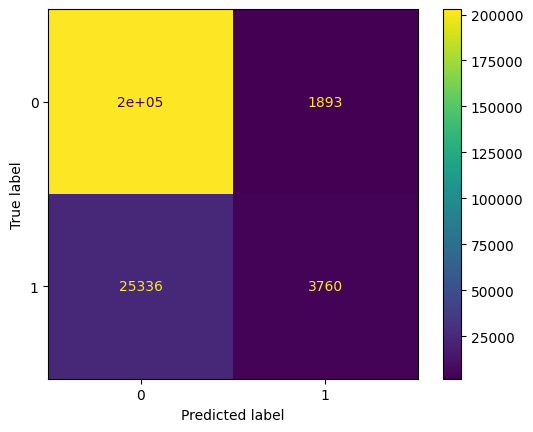

In [55]:
confusionMatricePlot(y_test, y_prediction)

***
### Naive Bayes
***

In [59]:
from sklearn.inspection import permutation_importance
from sklearn.naive_bayes import MultinomialNB

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]
X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=142, test_size=0.25, shuffle=True, )
classifier = MultinomialNB(alpha=1)

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X, y, cv=5, scoring=custom_scorer)

classifier.fit(X, y)
y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())

end_time = time.time()

Original dataset shape Counter({0: 812261, 1: 114980})
Resampled dataset shape Counter({0: 114980, 1: 114980})
Cross-validation scores: [0.42409473 0.46099943 0.45224912 0.41017845 0.39106312]
Mean CV score: 0.4277169718998044


In [60]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.43
Accuracy: 0.62
Precision: 0.64
Recall: 0.57
f1_score: 0.60
Running time : 0.01 min


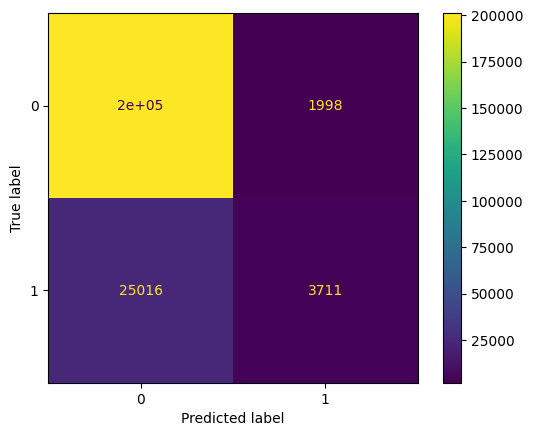

In [73]:
confusionMatricePlot(y_test, y_prediction)

***
### Gradient-Boosting
***

In [61]:
from sklearn.ensemble import GradientBoostingClassifier

start_time = time.time()

X = df_model[col_independent]
y = df_model[col_dependent]

X, y = randomUnderSampling(X, y)

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.25, shuffle=True)

classifier = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, max_depth=1, random_state=0, min_samples_split=2).fit(X_train, y_train)
classifier.score(X_test, y_test)

custom_scorer = make_scorer(custom_evaluation_score)
cv_scores = cross_val_score(classifier, X, y, cv=5, scoring=custom_scorer)

y_prediction = classifier.predict(X_test)

print("Cross-validation scores:", cv_scores)
print("Mean CV score:", cv_scores.mean())
end_time = time.time()

Original dataset shape Counter({0: 812261, 1: 114980})
Resampled dataset shape Counter({0: 114980, 1: 114980})
Cross-validation scores: [0.43231109 0.42392547 0.44332711 0.42281555 0.36870829]
Mean CV score: 0.41821750204829283


In [62]:
modelScore(y_test, y_prediction)
durationTime(start_time, end_time)

Évaluation : 0.5
Accuracy: 0.69
Precision: 0.72
Recall: 0.63
f1_score: 0.67
Running time : 1.87 min


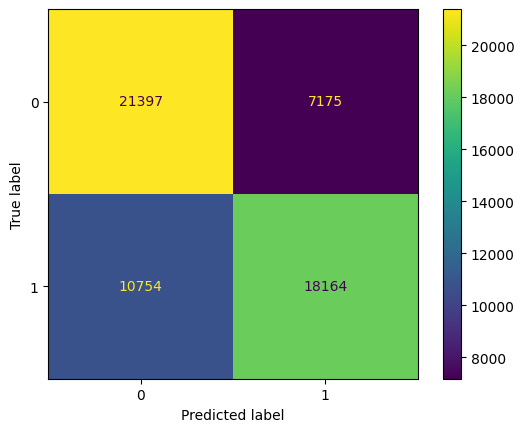

In [63]:
confusionMatricePlot(y_test, y_prediction)